In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

from google.colab import drive
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
num_epochs = 60
learning_rate = 0.001
batch_size = 32
use_cbam = False

In [ ]:
if use_cbam:
  results_filename = '/content/gdrive/My Drive/Deep Learning/Project/CIFAR100/Results_CBAM.csv'
  models_dirname = '/content/gdrive/My Drive/Deep Learning/Project/CIFAR100/Models/CBAM'
else:
  results_filename = '/content/gdrive/My Drive/Deep Learning/Project/CIFAR100/Results_NO_CBAM.csv'
  models_dirname = '/content/gdrive/My Drive/Deep Learning/Project/CIFAR100/Models/NO_CBAM'

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
classes = trainset.classes

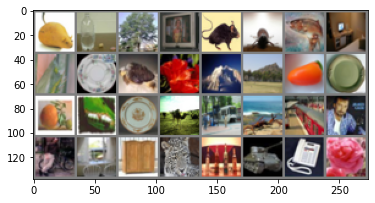

 pear bottle oak_tree television mouse beetle trout television caterpillar plate turtle tulip mountain mountain sweet_pepper plate orange caterpillar plate camel streetcar lobster train   man   man table wardrobe leopard bottle  tank telephone tulip


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [ ]:
class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=1, groups=1)
        self.bn = nn.BatchNorm2d(out_planes,eps=1e-5, momentum=0.01, affine=True)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return x

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class ChannelGate(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max']):
        super(ChannelGate, self).__init__()
        self.gate_channels = gate_channels
        self.mlp = nn.Sequential(
            Flatten(),
            nn.Linear(gate_channels, gate_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(gate_channels // reduction_ratio, gate_channels)
            )
        self.pool_types = pool_types
    def forward(self, x):
        channel_att_sum = None
        for pool_type in self.pool_types:
            if pool_type=='avg':
                avg_pool = F.avg_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( avg_pool )
            elif pool_type=='max':
                max_pool = F.max_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( max_pool )

            if channel_att_sum is None:
                channel_att_sum = channel_att_raw
            else:
                channel_att_sum = channel_att_sum + channel_att_raw

        scale = F.sigmoid( channel_att_sum ).unsqueeze(2).unsqueeze(3).expand_as(x)
        return x * scale

class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1 )

class SpatialGate(nn.Module):
    def __init__(self):
        super(SpatialGate, self).__init__()
        kernel_size = 7
        self.compress = ChannelPool()
        self.spatial = BasicConv(2, 1, kernel_size, stride=1, padding=(kernel_size-1) // 2)
    def forward(self, x):
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = F.sigmoid(x_out)
        return x * scale

class CBAM(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max']):
        super(CBAM, self).__init__()
        self.ChannelGate = ChannelGate(gate_channels, reduction_ratio, pool_types)
        self.SpatialGate = SpatialGate()
    def forward(self, x):
        x_out = self.ChannelGate(x)
        x_out = self.SpatialGate(x_out)
        return x_out

In [ ]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, use_cbam=False):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

        if use_cbam:
            self.cbam = CBAM( planes, 16 )
        else:
            self.cbam = None

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        if not self.cbam is None:
            out = self.cbam(out)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes, use_cbam):
        self.use_cbam = use_cbam
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(block, 64,  layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.fc = nn.Linear(512 * block.expansion, num_classes)

        init.kaiming_normal(self.fc.weight)
        for key in self.state_dict():
            if key.split('.')[-1]=="weight":
                if "conv" in key:
                    init.kaiming_normal(self.state_dict()[key], mode='fan_out')
                if "bn" in key:
                    if "SpatialGate" in key:
                        self.state_dict()[key][...] = 0
                    else:
                        self.state_dict()[key][...] = 1
            elif key.split(".")[-1]=='bias':
                self.state_dict()[key][...] = 0

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, use_cbam = self.use_cbam))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, use_cbam = self.use_cbam))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)

        x = self.layer2(x)

        x = self.layer3(x)

        x = self.layer4(x)

        x = F.avg_pool2d(x, 4)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
net = ResNet(BasicBlock, [3, 4, 6, 3], len(classes), use_cbam=use_cbam)
net.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
print("Model Initialised")

Model Initialised


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

In [ ]:
results = pd.DataFrame(columns=["Epoch", "Trainset Top1 Error", "Testset Top1 Error", "Trainset Top5 Error", "Testset Top5 Error", "Trainset Loss", "Testset Loss", "Trainset Accuracy", "Testset Accuracy", "Trainset Classwise Accuracy", "Testset Classwise Accuracy"])

In [ ]:
for epoch in range(num_epochs):

  running_loss = 0.0
  total = 0
  correct = 0
  correct5 = 0
  classwise_correct = {key: 0 for key in classes}
  classwise_total = {key: 0 for key in classes}

  print(f"\nEpoch {epoch+1}\n")

  print("\nTraining\n")

  for data in tqdm(trainloader):
      inputs, labels = data
      if torch.cuda.is_available():
          inputs, labels = inputs.cuda(), labels.cuda()

      optimizer.zero_grad()

      outputs = net(inputs)

      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

      for i in range(labels.size(0)):
        label = classes[labels[i].item()]
        classwise_correct[label] += (predicted[i].item() == labels[i].item())
        classwise_total[label] += 1

        correct5 += (labels[i].item() in outputs[i].data.cpu().numpy().argsort()[-5:])

      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
  
  train_loss = running_loss
  train_accuracy = (correct/total)*100
  train_classwise_accuracy = {key: ((classwise_correct[key]/classwise_total[key])*100) for key in classes}
  train_top1 = 100 - train_accuracy
  train_top5 = (1 - (correct5 / total) ) * 100

  print(f"\nLoss = {train_loss}, Accuracy = {train_accuracy}\n")
  print(f"\nClasswise Accuracy = {train_classwise_accuracy}\n")
  print(f"\nTop-1 Error %% = {train_top1}\n")
  print(f"\nTop-5 Error %% = {train_top5}\n")

  running_loss = 0.0
  total = 0
  correct = 0
  correct5 = 0
  classwise_correct = {key: 0 for key in classes}
  classwise_total = {key: 0 for key in classes}

  print("\nTesting\n")

  with torch.no_grad():
    for data in tqdm(testloader):
        inputs, labels = data
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        optimizer.zero_grad()

        outputs = net(inputs)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        for i in range(labels.size(0)):
          label = classes[labels[i].item()]
          classwise_correct[label] += (predicted[i].item() == labels[i].item())
          classwise_total[label] += 1

          correct5 += (labels[i].item() in outputs[i].data.cpu().numpy().argsort()[-5:])

        loss = criterion(outputs, labels)
        running_loss += loss.item()
  
  test_loss = running_loss
  test_accuracy = (correct/total)*100
  test_classwise_accuracy = {key: ((classwise_correct[key]/classwise_total[key])*100) for key in classes}
  test_top1 = 100 - test_accuracy
  test_top5 = (1 - (correct5 / total) ) * 100

  print(f"\nLoss = {test_loss}, Accuracy = {test_accuracy}\n")
  print(f"\nClasswise Accuracy = {test_classwise_accuracy}\n")
  print(f"\nTop-1 Error %% = {test_top1}\n")
  print(f"\nTop-5 Error %% = {test_top5}\n")

  results = results.append({"Epoch": (epoch+1), \
                            "Trainset Top1 Error": train_top1, "Testset Top1 Error": test_top1, \
                            "Trainset Top5 Error": train_top5, "Testset Top5 Error": test_top5, \
                            "Trainset Loss": train_loss, "Testset Loss": test_loss, \
                            "Trainset Accuracy": train_accuracy, "Testset Accuracy": test_accuracy, \
                            "Trainset Classwise Accuracy": train_classwise_accuracy, "Testset Classwise Accuracy": test_classwise_accuracy}, \
                           ignore_index=True)
  
  torch.save(net.state_dict(), models_dirname+f"/{epoch+1}.pth")
  results.to_csv(results_filename)


Epoch 1


Training





Loss = 6139.729823350906, Accuracy = 10.814


Classwise Accuracy = {'apple': 24.2, 'aquarium_fish': 11.799999999999999, 'baby': 8.6, 'bear': 1.6, 'beaver': 1.2, 'bed': 2.8000000000000003, 'bee': 2.4, 'beetle': 2.8000000000000003, 'bicycle': 1.4000000000000001, 'bottle': 3.2, 'bowl': 0.0, 'boy': 0.6, 'bridge': 3.8, 'bus': 4.6, 'butterfly': 10.2, 'camel': 3.0, 'can': 5.0, 'castle': 15.4, 'caterpillar': 17.599999999999998, 'cattle': 0.4, 'chair': 34.599999999999994, 'chimpanzee': 22.2, 'clock': 0.8, 'cloud': 33.6, 'cockroach': 26.0, 'couch': 1.0, 'crab': 1.4000000000000001, 'crocodile': 12.0, 'cup': 3.2, 'dinosaur': 3.5999999999999996, 'dolphin': 22.0, 'elephant': 4.0, 'flatfish': 0.0, 'forest': 16.6, 'fox': 3.8, 'girl': 1.6, 'hamster': 17.599999999999998, 'house': 7.000000000000001, 'kangaroo': 5.2, 'keyboard': 1.6, 'lamp': 1.4000000000000001, 'lawn_mower': 29.799999999999997, 'leopard': 14.799999999999999, 'lion': 20.0, 'lizard': 0.6, 'lobster': 3.2, 'man': 2.1999999999999997, 'maple_



Loss = 1115.098462820053, Accuracy = 16.55


Classwise Accuracy = {'apple': 44.0, 'aquarium_fish': 28.000000000000004, 'baby': 23.0, 'bear': 1.0, 'beaver': 2.0, 'bed': 19.0, 'bee': 4.0, 'beetle': 5.0, 'bicycle': 0.0, 'bottle': 20.0, 'bowl': 0.0, 'boy': 0.0, 'bridge': 12.0, 'bus': 16.0, 'butterfly': 8.0, 'camel': 3.0, 'can': 7.000000000000001, 'castle': 4.0, 'caterpillar': 42.0, 'cattle': 1.0, 'chair': 46.0, 'chimpanzee': 42.0, 'clock': 0.0, 'cloud': 55.00000000000001, 'cockroach': 31.0, 'couch': 4.0, 'crab': 3.0, 'crocodile': 14.000000000000002, 'cup': 9.0, 'dinosaur': 4.0, 'dolphin': 28.000000000000004, 'elephant': 8.0, 'flatfish': 2.0, 'forest': 18.0, 'fox': 0.0, 'girl': 9.0, 'hamster': 11.0, 'house': 0.0, 'kangaroo': 10.0, 'keyboard': 3.0, 'lamp': 1.0, 'lawn_mower': 44.0, 'leopard': 16.0, 'lion': 28.000000000000004, 'lizard': 1.0, 'lobster': 2.0, 'man': 11.0, 'maple_tree': 25.0, 'motorcycle': 20.0, 'mountain': 28.000000000000004, 'mouse': 0.0, 'mushroom': 18.0, 'oak_tree': 62.0, '



Loss = 5245.457099676132, Accuracy = 20.024


Classwise Accuracy = {'apple': 39.6, 'aquarium_fish': 23.799999999999997, 'baby': 17.8, 'bear': 3.8, 'beaver': 8.4, 'bed': 13.0, 'bee': 9.6, 'beetle': 14.2, 'bicycle': 13.600000000000001, 'bottle': 26.200000000000003, 'bowl': 0.6, 'boy': 4.0, 'bridge': 20.0, 'bus': 22.8, 'butterfly': 20.0, 'camel': 12.2, 'can': 15.0, 'castle': 34.599999999999994, 'caterpillar': 24.0, 'cattle': 4.8, 'chair': 39.4, 'chimpanzee': 41.0, 'clock': 1.4000000000000001, 'cloud': 47.599999999999994, 'cockroach': 43.4, 'couch': 6.4, 'crab': 1.4000000000000001, 'crocodile': 12.8, 'cup': 13.200000000000001, 'dinosaur': 11.200000000000001, 'dolphin': 26.200000000000003, 'elephant': 7.199999999999999, 'flatfish': 2.4, 'forest': 22.6, 'fox': 3.5999999999999996, 'girl': 6.4, 'hamster': 25.4, 'house': 14.799999999999999, 'kangaroo': 15.0, 'keyboard': 6.800000000000001, 'lamp': 4.0, 'lawn_mower': 48.0, 'leopard': 16.2, 'lion': 26.200000000000003, 'lizard': 2.0, 'lobster': 7

In [ ]:
correct5

In [ ]:
total